In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from maraboupy import Marabou
from datetime import datetime

Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\Leon\Downloads\Marabou-master\Marabou-master\maraboupy\Marabou.py:31: UserWarning: ONNX parser is unavailable because onnx or onnxruntime packages are not installed
  warnings.warn("ONNX parser is unavailable because onnx or onnxruntime packages are not installed")


In [2]:
TF_TRAIN_SHUFFLE = 10_000
TF_TRAIN_BATCH = 32
TF_TRAIN_EPOCHS = 5

In [3]:
MB_MODEL_PATH = "mnist_model"
MB_NUM_SAMPLES = 25

In [4]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
train_x = train_x.reshape((train_x.shape[0], 784)) / 255.0
test_x = test_x.reshape((test_x.shape[0], 784)) / 255.0
print("train data shape", train_x.shape, train_y.shape)
print("test data shape", test_x.shape, test_y.shape)

train data shape (60000, 784) (60000,)
test data shape (10000, 784) (10000,)


In [5]:
train_data = tf.data.Dataset \
    .from_tensor_slices((train_x, train_y)) \
    .shuffle(TF_TRAIN_SHUFFLE) \
    .batch(TF_TRAIN_BATCH)

In [6]:
tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(784)),
    tf.keras.layers.Dense(16, activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Dense(16, activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Dense(10),
])

In [7]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [8]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()
tf_model.compile(loss=loss_fn, metrics=[metric_fn])

In [9]:
tf_model.fit(train_data, epochs=TF_TRAIN_EPOCHS)

Epoch 1/5
1875/1875 [==============================] - 1s 566us/step - loss: 0.7317 - sparse_categorical_accuracy: 0.7982
Epoch 2/5
1875/1875 [==============================] - 1s 603us/step - loss: 0.2675 - sparse_categorical_accuracy: 0.9239
Epoch 3/5
1875/1875 [==============================] - 1s 612us/step - loss: 0.2340 - sparse_categorical_accuracy: 0.9346
Epoch 4/5
1875/1875 [==============================] - 1s 600us/step - loss: 0.2052 - sparse_categorical_accuracy: 0.9421
Epoch 5/5
1875/1875 [==============================] - 1s 603us/step - loss: 0.1856 - sparse_categorical_accuracy: 0.9473


In [10]:
tf_model.evaluate(test_x, test_y)

313/313 [==============================] - 0s 320us/step - loss: 0.1813 - sparse_categorical_accuracy: 0.9501


[0.18131233751773834, 0.9501000046730042]

In [11]:
tf.saved_model.save(tf_model, MB_MODEL_PATH)

INFO:tensorflow:Assets written to: mnist_model\assets


INFO:tensorflow:Assets written to: mnist_model\assets


In [12]:
measurements = []

In [13]:
for epsilon in [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3 ]:
    for delta in [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3 ]:
        
        start_times, stop_times, nfound = [], [], 0
        
        samples_to_try = zip(
            train_x[:MB_NUM_SAMPLES],
            train_y[:MB_NUM_SAMPLES]
        )
        for sample_index, (image, actual_label) in enumerate(samples_to_try):
            
            start_times.append(datetime.now())
    
            for target_label in range(10):
                if target_label == actual_label: continue
        
                mb_model = Marabou.read_tf(MB_MODEL_PATH, modelType="savedModel_v2")
                mb_input_vars = mb_model.inputVars[0][0]
                mb_output_vars = mb_model.outputVars[0]
        
                for variable, value in enumerate(image):
                    mb_model.setLowerBound(mb_input_vars[variable], value - delta)
                    mb_model.setUpperBound(mb_input_vars[variable], value + delta)

                mb_model.addInequality(
                    [ mb_output_vars[actual_label], mb_output_vars[target_label] ],
                    [ +1.0, -1.0 ], -1.0 * epsilon
                )
        
                mb_variables, stats = mb_model.solve("marabou.log", verbose=False)
                if mb_variables:
                    nfound = nfound + 1
                    break

            stop_times.append(datetime.now())
        
        times = [
            (stop_times[i] - start_times[i]).total_seconds()
            for i in range(MB_NUM_SAMPLES)
        ]
        
        measurement = {
            "epsilon": epsilon, "delta": delta,
            "times": times, "nfound": nfound,
        }
        measurements.append(measurement)
        print(measurement)

{'epsilon': 0.005, 'delta': 0.005, 'times': [4.685155, 4.476322, 4.963303, 5.048593, 4.537713, 4.491411, 5.363441, 4.409579, 4.919583, 4.546218, 4.931765, 4.811795, 4.405885, 4.45844, 4.967932, 4.579811, 4.681571, 4.75942, 3.694973, 4.659919, 4.4499, 4.45009, 5.061902, 4.964507, 1.164712], 'nfound': 2}
{'epsilon': 0.005, 'delta': 0.01, 'times': [2.750295, 4.988021, 5.312478, 5.182414, 4.979972, 4.995299, 5.245764, 4.944964, 5.308021, 5.240682, 5.321949, 5.349365, 5.183916, 5.153039, 5.317294, 4.994898, 5.063473, 5.11486, 4.165242, 5.350357, 4.988575, 4.874874, 6.543041, 5.249664, 0.684014], 'nfound': 3}
{'epsilon': 0.005, 'delta': 0.05, 'times': [27.827334, 177.272852, 8.988913, 1.460785, 175.518423, 113.963549, 7.582126, 10.446456, 144.768963, 67.923645, 1.392657, 1.94755, 42.700733, 11.118714, 64.644075, 1.400323, 1.114109, 25.638682, 0.961083, 32.959593, 11.183238, 30.628177, 1.60271, 1.669908, 0.649712], 'nfound': 24}
{'epsilon': 0.005, 'delta': 0.1, 'times': [1.519937, 2.034748, 1

In [15]:
print(len(measurements))

36


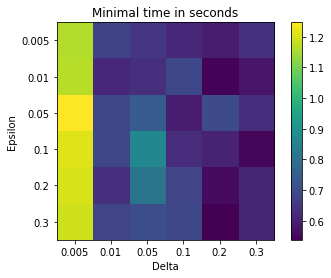

In [57]:
delta_axis = [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3 ]
epsilon_axis = [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3 ]

data = [
    [
        np.min(measurements[j * len(epsilon_axis) + i]["times"])
        for i in range(len(delta_axis))
    ]
    for j in range(len(epsilon_axis))
]

fig, ax = plt.subplots()
im = ax.imshow(data)
fig.colorbar(im, ax=ax)

ax.set_xlabel("Delta")
ax.set_xticks(np.arange(len(delta_axis)))
ax.set_xticklabels(delta_axis)

ax.set_ylabel("Epsilon")
ax.set_yticks(np.arange(len(epsilon_axis)))
ax.set_yticklabels(epsilon_axis)

ax.set_title("Minimal time in seconds")

fig.savefig("perftest-mintime.png")

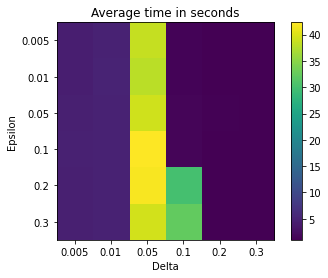

In [56]:
delta_axis = [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3 ]
epsilon_axis = [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3 ]

data = [
    [
        np.average(measurements[j * len(epsilon_axis) + i]["times"])
        for i in range(len(delta_axis))
    ]
    for j in range(len(epsilon_axis))
]

fig, ax = plt.subplots()
im = ax.imshow(data)
fig.colorbar(im, ax=ax)

ax.set_xlabel("Delta")
ax.set_xticks(np.arange(len(delta_axis)))
ax.set_xticklabels(delta_axis)

ax.set_ylabel("Epsilon")
ax.set_yticks(np.arange(len(epsilon_axis)))
ax.set_yticklabels(epsilon_axis)

ax.set_title("Average time in seconds")

fig.savefig("perftest-avgtime.png")

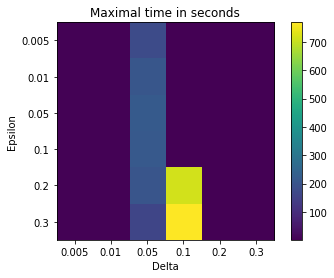

In [55]:
delta_axis = [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3 ]
epsilon_axis = [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3 ]

data = [
    [
        np.max(measurements[j * len(epsilon_axis) + i]["times"])
        for i in range(len(delta_axis))
    ]
    for j in range(len(epsilon_axis))
]

fig, ax = plt.subplots()
im = ax.imshow(data)
fig.colorbar(im, ax=ax)

ax.set_xlabel("Delta")
ax.set_xticks(np.arange(len(delta_axis)))
ax.set_xticklabels(delta_axis)

ax.set_ylabel("Epsilon")
ax.set_yticks(np.arange(len(epsilon_axis)))
ax.set_yticklabels(epsilon_axis)

ax.set_title("Maximal time in seconds")

fig.savefig("perftest-maxtime.png")

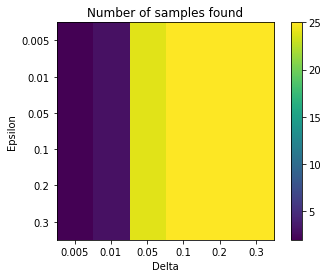

In [54]:
delta_axis = [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3 ]
epsilon_axis = [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3 ]

data = [
    [
        measurements[j * len(epsilon_axis) + i]["nfound"]
        for i in range(len(delta_axis))
    ]
    for j in range(len(epsilon_axis))
]

fig, ax = plt.subplots()
im = ax.imshow(data)
fig.colorbar(im, ax=ax)

ax.set_xlabel("Delta")
ax.set_xticks(np.arange(len(delta_axis)))
ax.set_xticklabels(delta_axis)

ax.set_ylabel("Epsilon")
ax.set_yticks(np.arange(len(epsilon_axis)))
ax.set_yticklabels(epsilon_axis)

ax.set_title("Number of samples found")

fig.savefig("perftest-nfound.png")